# Estimate scavenging rates from observations

Dissolved trace metal data from Manuel Colombo, particulate trace metal data from Jingxuan Li.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
import seaborn as sns; sns.set()
import netCDF4 as nc
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
from scipy.signal import savgol_filter

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Load files:

In [3]:
# Dissolved trace metal observations
Pb_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = Pb_data['Station names'].dropna().astype('str')
lons = Pb_data['station lon'].astype('float').dropna().values
lats = Pb_data['Station lat'].astype('float').dropna().values

#### Functions

In [4]:
def assoc_depth(Al, Pb, depth_obs1, depth_obs2):
    
    # find depths that are in common
    pAl = np.copy(Al)
    dPb = np.empty_like(depth_obs1)
    
    i=0
    for depth in depth_obs1:
        min_val  = np.argmin(np.abs(depth_obs2 - depth))
        if np.abs(depth_obs2[min_val] - depth) > 20:
            pAl[i]           = np.nan
            dPb[i]           = np.nan
        else:
            dPb[i]           = Pb[min_val]
        i+=1
        
    return dPb, pAl

In [86]:
def pair_samples(stn_name, chunks=False, slope=False):
    
    if stn_name[0:3]=='CAA':
        number = int(stn_name[3])+3
    elif stn_name[0:2]=='CB':
        number = int(stn_name[2])+12
    else:
        number = int(stn_name[2])
        
    depth_column = 'Depth.'+str(number)
    
    particulate_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/pTM_Maldonado_DATA_v2_notes.csv')
    dissolved_data   = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')

    #------------ load data at this station -------------------------------------------------
    # particulate
    stns   = particulate_data['GEOTR_STN'].astype('str')
    pAl    = particulate_data['Al (nmol/L)'].where(stns == stn_name).apply(pd.to_numeric, errors='coerce').dropna().astype('float')
    pdep   = particulate_data['CTDPRS (DBAR)'].where(stns == stn_name).dropna().astype('float')
    pdepth = [pdep[i] for i in pAl.index.values]
    
    # dissolved
    dPb    = dissolved_data[stn_name][np.isfinite(Pb_data[stn_name])].astype('float')
    ddepth = dissolved_data[depth_column][np.isfinite(Pb_data[stn_name])].astype('float') ## fix: depth index
    
    #------------ compare depths ------------------------------------------------------------
    dPb_match, pAl_match = assoc_depth(pAl, dPb, pdepth, ddepth)
    
    ddepth = np.array(ddepth); pdepth = np.array(pdepth);
    
    if chunks:
        # Estimate the drop over chunks of depth:
        chunk      = 30
        try:
            num_chunks = np.int(np.floor(np.divide(np.min([np.max(ddepth), np.max(pdepth)]),chunk)))

            Pb_drop_ch = []; Al_ch = [];
            for i in range(1,num_chunks):
                Pb_drop_chunk = np.ma.mean(dPb[(ddepth > chunk*(int(i-1))) & (ddepth < chunk*int(i))]) - \
                                np.ma.mean(dPb[(ddepth > chunk*int(i))     & (ddepth < chunk*(int(i+1)))])
                Al_chunk      = np.ma.mean(pAl[(pdepth > chunk*int(i))     & (pdepth < chunk*(int(i+1)))])

                Pb_drop_ch.append(Pb_drop_chunk)
                Al_ch.append(Al_chunk)

            return Al_ch, Pb_drop_ch
        except:
            return [], []
    elif slope:
        # Estimate the difference between the surface maximum and deeper average
        drop_Al = np.mean(pAl)
        drop_Pb = np.max(dPb[ddepth < 100]) - np.mean(dPb[ddepth > 100])
        return drop_Al, drop_Pb
    else:
        return pAl_match, dPb_match

##### Calculations

### Dissolved Pb vs. particulate Aluminium

In [63]:
cmap_CB  = sns.color_palette("Blues", 4)
cmap_BB  = sns.color_palette("Reds", 3)
cmap_CAA = sns.color_palette("BrBG", 9)   

stn_colors = cmap_CB + cmap_CAA + cmap_BB 

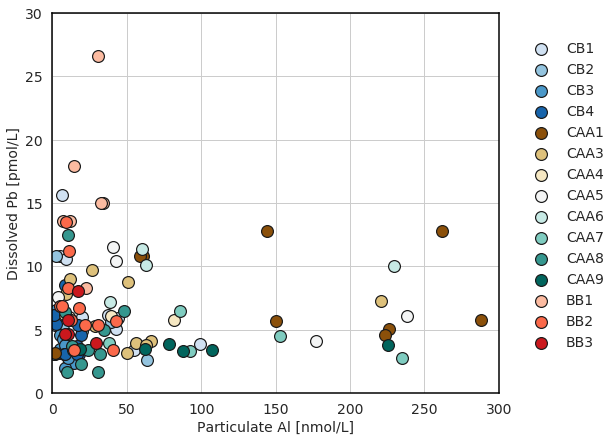

In [64]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(8,7))
    ax.set(xlim=(0,300), ylim=(0,30.0))
    
    n=0
    for station in ['CB1', 'CB2', 'CB3', 'CB4', 'CAA1', 'CAA2', 'CAA3', \
                'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9','BB1', 'BB2', 'BB3']:
        pAl_stn, dPb_stn = pair_samples(station)
        sns.scatterplot(pAl_stn, dPb_stn*1e3, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[n], \
                        label=station)
        n+=1
    
    ax.legend(loc=(1.05, 0.1), fontsize=14, frameon=False)
    ax.set_ylabel('Dissolved Pb [pmol/L]', fontsize=14)
    ax.set_xlabel('Particulate Al [nmol/L]', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

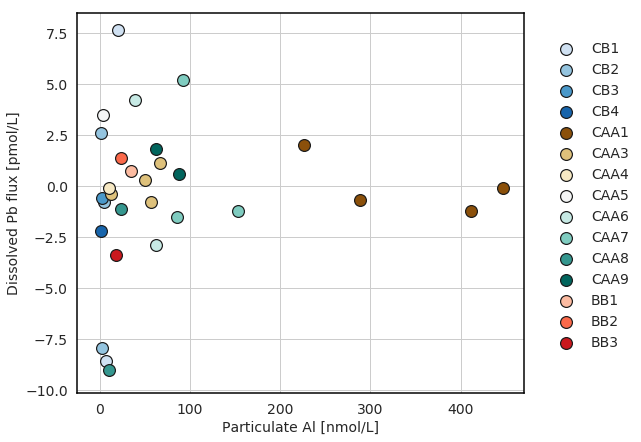

In [70]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(8,7))
#     ax.set(xlim=(0,300), ylim=(0,30.0))
    
    n=0
    for station in ['CB1', 'CB2', 'CB3', 'CB4', 'CAA1', 'CAA2', 'CAA3', \
                'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9','BB1', 'BB2', 'BB3']:
        pAl_stn, dPb_stn = pair_samples(station, chunks=True)
        sns.scatterplot(pAl_stn, np.array(dPb_stn)*1e3, s=140, edgecolor='k', linewidth=1.2, color=stn_colors[n], \
                        label=station)
        n+=1
    
    ax.legend(loc=(1.05, 0.1), fontsize=14, frameon=False)
    ax.set_ylabel('Dissolved Pb flux [pmol/L]', fontsize=14)
    ax.set_xlabel('Particulate Al [nmol/L]', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

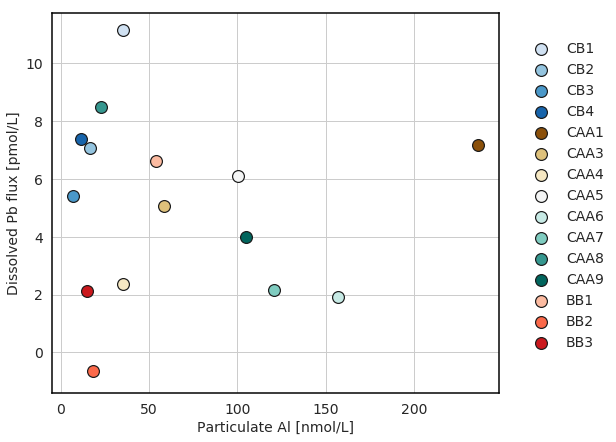

In [87]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1,figsize=(8,7))
#     ax.set(xlim=(0,300), ylim=(0,30.0))
    
    n=0
    for station in ['CB1', 'CB2', 'CB3', 'CB4', 'CAA1', 'CAA2', 'CAA3', \
                'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9','BB1', 'BB2', 'BB3']:
        pAl_stn, dPb_stn = pair_samples(station, slope=True)
        sns.scatterplot([pAl_stn], [dPb_stn*1e3], label=station, \
                        s=140, edgecolor='k', linewidth=1.2, color=stn_colors[n])
        n+=1
    
    ax.legend(loc=(1.05, 0.1), fontsize=14, frameon=False)
    ax.set_ylabel('Dissolved Pb flux [pmol/L]', fontsize=14)
    ax.set_xlabel('Particulate Al [nmol/L]', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

### Alternate idea: use a combination of pAl and POC to estimate scavenging